<a href="https://colab.research.google.com/github/hqanhh/PlateRecognition/blob/main/Pytorch_PlateRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/grive')

Mounted at /content/grive


In [ ]:
from google.colab.patches import cv2_imshow
import functools
import cv2
import numpy as np
from os.path import splitext
from keras.models import model_from_json

In [ ]:
#DETECT LICENSE PLATE BY PRE-TRAINED MODEL WPOD-NET
#http://sergiomsilva.com/pubs/alpr-unconstrained/

In [ ]:
class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    # Make a copy
    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    # Find width and height
    def wh(self): return self.__br - self.__tl

    # Find center point
    def cc(self): return self.__tl + self.wh() / 2

    # Get coordinate of top left
    def tl(self): return self.__tl

    # Get coordinate of bottom right
    def br(self): return self.__br

    # Get coordinate of top right
    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    # Get coordinate of bottom left
    def bl(self): return np.array([self.__tl[0], self.__br[1]])
    
    # Return class
    def cl(self): return self.__cl

    # Calculate area 
    def area(self): return np.prod(self.wh())

    # Return probability
    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

In [ ]:
class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

In [ ]:
#Normalize picture
def imnormalize(Image):
    return Image.astype('float32') / 255

#Width and height
def getWH(image):
    return np.array(image[1::-1]).astype(float)

#Find intersection over union area
def IOU(tl1, br1, tl2, br2):
    wh1 = br1-tl1
    wh2 = br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersect_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersect_area = np.prod(intersect_wh)
    area1 = np.prod(wh1)
    area2 = np.prod(wh2)
    union_area = area1 + area2 - intersect_area
    return intersect_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for selected in SelectedLabels:
            if IOU_labels(label, selected) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels

def load_model(path):
    path = splitext(path)[0]
    with open('%s.json' % path, 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json, custom_objects={})
    model.load_weights('%s.h5' % path)
    return model

def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

# Get 4 edge of rectangle
def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop


In [ ]:
# Reconstruct function to cut license plate from original image
def reconstruct(Im, Imresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    stride = 2**4
    side = ((208 + 40)/2)/stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 200)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Imresized.shape)
    # Output feature map size
    MN = WH/stride

    vxx = vyy = 0.5 #alpha
    filt = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # Affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # Identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*filt(vxx, vyy))
        pts_frontal = np.array(B*filt(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))

    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    print(final_labels_frontal)

    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    license_plates = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(Im.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            # Applies perspective transformation
            lp = cv2.warpPerspective(Im, H, out_size, borderValue=0)
            license_plates.append(lp)
    print(final_labels)
    return final_labels, license_plates, lp_type

In [ ]:
def detect_lp(model, Im, max_dim, lp_threshold):

    # Calculate factor to resize  the image
    min_dim_img = min(Im.shape[:2])
    factor = float(max_dim) / min_dim_img

    # Calculate new weight and height
    w, h = (np.array(Im.shape[1::-1], dtype=float) * factor).astype(int).tolist()

    # Resize image
    Imresized = cv2.resize(Im, (w, h))

    T = Imresized.copy()

    # Convert to Tensor
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))

    # Use Wpod-net pretrain to detect license plate
    pred = model.predict(T)

    # Remove axes of length one from pred
    pred = np.squeeze(pred)

    print(pred.shape)

    # Reconstruct and return license plate (1: long, 2: square)
    L, TLp, lp_type = reconstruct(Im, Imresized, pred, lp_threshold)

    return L, TLp, lp_type

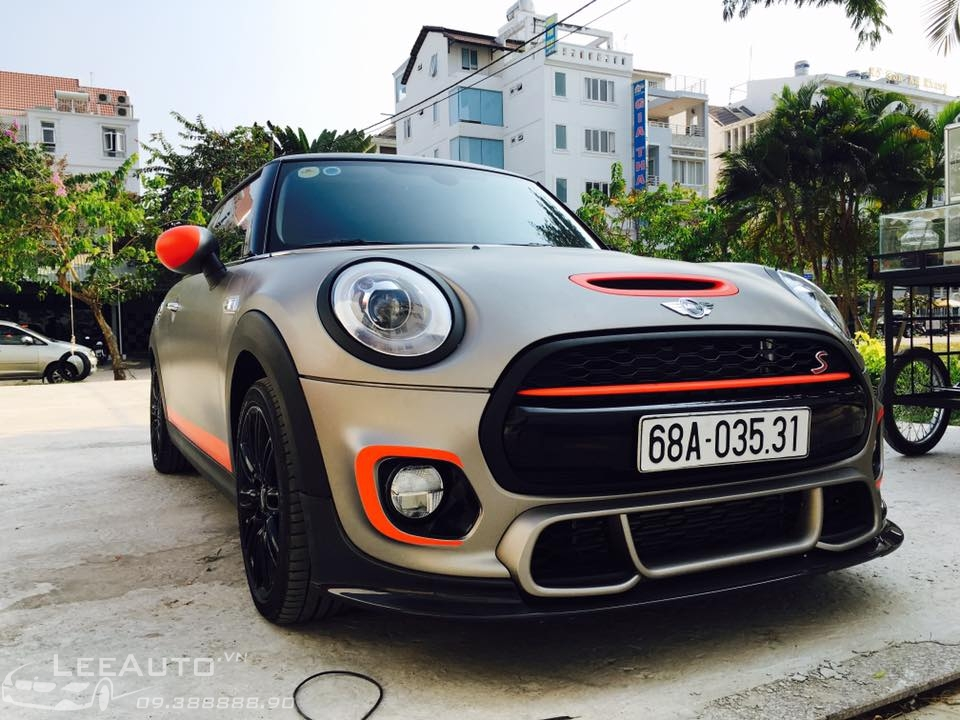

(24, 32, 8)


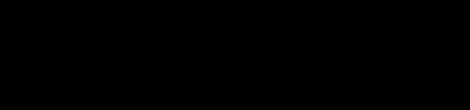

In [ ]:
# Name picture
img_path = "/content/grive/MyDrive/dataset/fullpic/test.jpg"

# Load model LP detection
wpod_net_path = "/content/grive/MyDrive/dataset/wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

# Read image
pic = cv2.imread(img_path)
cv2_imshow(pic)
cv2.waitKey(0)


# Max and min size of 1 dimenson of image
Dmax = 608
Dmin = 288

# Calculate ratio of weight/height and find the smallest
ratio = float(max(pic.shape[:2])) / min(pic.shape[:2])
side = int(ratio * Dmin)
bound_dim = min(side, Dmax)

_ , license_plate, lp_type = detect_lp(wpod_net, imnormalize(pic), bound_dim, lp_threshold=0.5)


if (len(license_plate)):
    cv2_imshow(cv2.cvtColor(license_plate[0],cv2.COLOR_RGB2BGR ))
    cv2.waitKey()

cv2.destroyAllWindows()

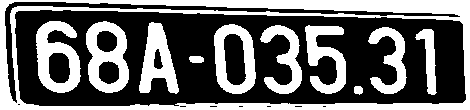

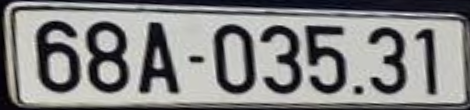

In [ ]:
#Scales, calculates absolute values, and converts the result to 8-bit.
license_plate[0] = cv2.convertScaleAbs(license_plate[0], alpha=(255.0))

plate = license_plate[0]

# Convert to gray picture
gray = cv2.cvtColor(license_plate[0], cv2.COLOR_BGR2GRAY)


# Apply threshold to extract numbers and background
#127:thresh, 255: maxval, if > thresh = 0 else 255
binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)[1]
#cv2.imshow("Picture after threshold", binary)
cv2_imshow(binary)
cv2.waitKey()
cv2_imshow(plate)

In [ ]:
# Perform connected components analysis on the thresholded images and
# initialize the mask to hold only the components we are interested in
_, labels = cv2.connectedComponents(binary)
# initialize an output mask to store all characters parsed from the license plate
mask = np.zeros(binary.shape, dtype="uint8")

# Set lower and upper bound criteria for characters
total_pixels = plate.shape[0] * plate.shape[1]
lower = total_pixels // 80 # heuristic param, can be fine tuned if necessary
upper = total_pixels // 10 # heuristic param, can be fine tuned if necessary

# Loop over the unique components
for (i, label) in enumerate(np.unique(labels)):
		# If this is the background label, ignore it
		if label == 0:
			continue
	
		# Otherwise, construct the label mask to display only connected component
		# for the current label
		labelMask = np.zeros(binary.shape, dtype="uint8")
		labelMask[labels == label] = 255
		numPixels = cv2.countNonZero(labelMask)
	
		# If the number of pixels in the component is between lower and upper bound, add it to our mask
		if upper > numPixels > lower:
			mask = cv2.add(mask, labelMask)

# Find contours and get bounding box for each contour
# RETR_EXTERNAL: retrieves only the extreme outer contours
# CHAIN_APPROX_SIMPLE: compresses horizontal, vertical, and diagonal segments and leaves only their end points
cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in cnts]

# Sort the bounding boxes from left to right, top to bottom
# sort by Y first, and then sort by X if Ys are similar
def compare(h1, h2):
    if abs(h1[1] - h2[1]) > 8:
        return h1[1] - h2[1]
    else:
        return h1[0] - h2[0]
boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare))

In [ ]:
for rect in boundingBoxes:
    print(rect)

(36, 21, 45, 72)
(86, 21, 43, 72)
(139, 22, 40, 72)
(214, 24, 42, 70)
(260, 25, 42, 69)
(305, 25, 41, 69)
(368, 27, 39, 67)
(415, 29, 22, 66)


In [ ]:
%pip install pytorchcv
%pip install torchinfo

     |████████████████████████████████| 532 kB 5.0 MB/s 


In [ ]:
#Import the packages needed.
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import pytorchcv
import torchvision.transforms as transforms
from torchinfo import summary

In [ ]:
std_normalize = transforms.Normalize(mean=[0.456],
                          std=[ 0.224])
trans = transforms.Compose([
        transforms.Resize([28, 28]),
        transforms.ToTensor(), 
        transforms.Grayscale(num_output_channels=1),
        std_normalize])
dataset = torchvision.datasets.ImageFolder('/content/grive/MyDrive/dataset/data',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[1000,len(dataset)-1000])


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        # Call a convolutional layer with input_channels = 1, output_channels = 10, kernel_size = 5
        self.conv1 = nn.Conv2d(1, 10, 5)
        # Max Pooling takes a sliding window (2*2) and replaces the window with the maximum value. 
        self.pool = nn.MaxPool2d(2, 2)
        # Call a convolutional layer with input_channels = 10, output_channels = 20, kernel_size = 5
        self.conv2 = nn.Conv2d(10, 20, 5)
        # 320 inputs, 31 outputs
        self.fc = nn.Linear(320,31)

    def forward(self, x):
        # We use relu activation function in between layers
        # Layer 1
        x = self.pool(nn.functional.relu(self.conv1(x)))
        # Layer 2
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # Flatten tensor shape to 320
        x = x.view(-1, 320)
        # Calculate softmax which return probabilities for 31 catogories
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN().to(device)
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            --                        --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 31]                   9,951
Total params: 15,231
Trainable params: 15,231
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.06
Estimated Total Size (MB): 0.12

In [ ]:
# Create 64-mini-batches of our datasets
train_loader = torch.utils.data.DataLoader(trainset,batch_size=64)
test_loader = torch.utils.data.DataLoader(testset,batch_size=64)

In [ ]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    # Activate training mode
    net.train()
    total_loss, acc, count = 0, 0, 0

    # Take a minibatch from dataset
    for features, labels in dataloader:
        # Move to gpu
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward and calculate the predicted result for this minibatch 
        out = net(features)
        # Calculate difference between this result and expected result
        loss = loss_fn(out,labels) 
        
        # Backward
        # Calculate the gradients of this loss function with respect to model weights (parameters), 
        # which are then used to adjust the weights to optimize the performance of the network.
        loss.backward()
        # Minimize the loss by adjusting weights of the network 
        optimizer.step()
        # Accumulate loss
        total_loss += loss
        # The predicted label is the index has highest value in the output
        _,predicted = torch.max(out,1)
        acc += (predicted==labels).sum()
        count += len(labels)
        #compute the number of correctly predicted cases
    return total_loss.item()/count, acc.item()/count

train_epoch(net,train_loader)

(0.028289867401123048, 0.478)

In [ ]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            # Move to gpu
            features = features.to(device)
            labels = labels.to(device)
            # Forward
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.01849458192257171, 0.8297872340425532)

In [ ]:
# Train the model for several epochs observing training and validation accuracy
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    # Choose optimizer
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        # Repeat those steps, one complete pass is called an epoch
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)

    return res

In [ ]:
# Train, return accuracy and loss in a "history" dictionary
history = train(net,train_loader,test_loader,epochs=20)

Epoch  0, Train acc=0.792, Val acc=0.872, Train loss=0.010, Val loss=0.013
Epoch  1, Train acc=0.924, Val acc=0.872, Train loss=0.003, Val loss=0.022
Epoch  2, Train acc=0.944, Val acc=0.872, Train loss=0.003, Val loss=0.017
Epoch  3, Train acc=0.952, Val acc=0.872, Train loss=0.002, Val loss=0.021
Epoch  4, Train acc=0.961, Val acc=0.915, Train loss=0.002, Val loss=0.017
Epoch  5, Train acc=0.968, Val acc=0.915, Train loss=0.001, Val loss=0.017
Epoch  6, Train acc=0.966, Val acc=0.894, Train loss=0.001, Val loss=0.018
Epoch  7, Train acc=0.967, Val acc=0.894, Train loss=0.001, Val loss=0.019
Epoch  8, Train acc=0.968, Val acc=0.936, Train loss=0.001, Val loss=0.011
Epoch  9, Train acc=0.979, Val acc=0.872, Train loss=0.001, Val loss=0.018
Epoch 10, Train acc=0.981, Val acc=0.915, Train loss=0.001, Val loss=0.020
Epoch 11, Train acc=0.987, Val acc=0.872, Train loss=0.001, Val loss=0.022
Epoch 12, Train acc=0.975, Val acc=0.851, Train loss=0.001, Val loss=0.032
Epoch 13, Train acc=0.982

In [ ]:
torch.save(net.state_dict(), "/content/grive/MyDrive/dataset/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = MultiLayerCNN()
model.load_state_dict(torch.load("/content/grive/MyDrive/dataset/model.pth"))

<All keys matched successfully>

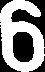

6


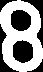

B


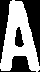

A


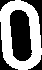

0


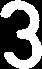

3


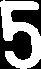

5


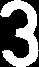

3


1
6BA03531


In [ ]:
plate_info = ''
for rect in boundingBoxes:
    # Get the coordinates from the bounding box
    x, y, w, h = rect

    # Crop the character from the mask
    crop = binary[y:y+h, x:x+w]
    cv2_imshow(crop)

    # Convert and normalize to have the same size as the train set
    crop = cv2.resize(crop, dsize=(28,28))
    convert = np.array(crop,dtype=np.float32)/255
    convert = convert.reshape(1, 1, 28, 28)
    convert = torch.from_numpy(convert)
    std_normalize = transforms.Normalize(mean=[0.456],
                          std=[0.224])
    final = std_normalize(convert)
    model.eval()
    with torch.no_grad():
        pred = model(final)
        #result = pred.argmax(1).item()
        result = torch.max(pred,1)[1].item()
        #print(pred)
    chars = [
    '0','1','A','B','C','D','E','F','G','H','K','L','2','M','N','P','R','S','T','U','V','X','Y','3','Z','4','5','6','7','8','9']
    
    print(chars[result])
    plate_info +=chars[result]
print(plate_info)